In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'

%pip install bdpy kornia



Mounted at /content/drive
/content/drive/My Drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.8 MB/s 
     |████████████████████████████████| 551 kB 64.9 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 


device(type='cpu')

In [ ]:
import csv
import fnmatch
import glob
import os
from datetime import datetime

import PIL.Image
# import caffe
import lmdb
import numpy as np
# from PIL.Image import resize as imresize

import bdpy
import lmdb
import pickle
from torchvision.transforms import Resize
import torchvision.transforms.functional as TF
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms.functional import equalize,rgb_to_grayscale
from kornia.enhance import equalize_clahe
import kornia
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [ ]:
class ImageObject:
    def __init__(self, image):
        # Dimensions of image for reconstruction - not really necessary 
        # for this dataset, but some datasets may include images of 
        # varying sizes
        self.channels = image.shape[2]
        self.size = image.shape[:2]
        self.image = image.tobytes()

    def get_image(self):
        """ Returns the image as a numpy array. """
        image = np.frombuffer(self.image, dtype=np.uint8)
        return image.reshape(*self.size, self.channels)
    
    


def create_lmdb(image_dir = "", output_dir = "",image_file_pattern ='*.JPEG', img_size = 248):
    """ Stores images to a LMDB.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
    """
    if os.path.exists(output_dir):
        print('%s already exists. Skipped.' % output_dir)
    else:
        os.makedirs(output_dir)
        
    image_list = glob.glob(os.path.join(image_dir, image_file_pattern))
    map_size = map_size = 100 * 1024 * len(image_list) * 10 * 10

    # Create a new LMDB environment
    env = lmdb.open(output_dir, map_size=map_size)

    # Start a new write transaction
    with env.begin(write=True) as txn:
        count = 0
        for image_file in image_list:
            image_id = os.path.splitext(os.path.basename(image_file))[0]
            image = PIL.Image.open(image_file)
            image = np.array(image)
             # Monochrome --> RGB
            if image.ndim == 2:
                img_rgb = np.zeros((image.shape[0], image.shape[1], 3), dtype=image.dtype)
                img_rgb[:, :, 0] = image
                img_rgb[:, :, 1] = image
                img_rgb[:, :, 2] = image
                image = img_rgb

            img_obj = ImageObject(image)
            key = image_id
            txn.put(key.encode("ascii"), pickle.dumps(img_obj))
            count = count + 1
            if count %100 == 0:
                print(count)
    env.close()


In [ ]:
# Run once to setup lmdb database
# create_lmdb("/data/images/training", "training")
# create_lmdb("/data/images/test", "test")

In [ ]:


batch_size = 64
momentum = 0.9
lr = 0.01
epochs = 20
log_interval = 100

class ImageReconstructionDataset(Dataset):

    def __init__(self, X_paths=[], y_path= ""):
        
    
        
        mris = []
        images = []
        env = lmdb.open(y_path)
        with env.begin(write=True) as txn:
            
            for path in X_paths:
                fmri_data_bd = bdpy.BData(path)
                # Get fMRI data in the ROI
                fmri_data = fmri_data_bd.select('ROI_VC = 1')

                # Normalize fMRI data
                fmri_data_mean = np.mean(fmri_data, axis=0)
                fmri_data_std = np.std(fmri_data, axis=0)

                fmri_data = (fmri_data - fmri_data_mean) / fmri_data_std
                fmri_data = fmri_data[:6000]
                mris.append(torch.from_numpy(fmri_data))
                fmri_labels = fmri_data_bd.get('Label')[:, 1].flatten()

                # Convet image labels in fMRI data from float to file name labes (str)
                fmri_labels = ['n%08d_%d' % (int(('%f' % a).split('.')[0]),
                                             int(('%f' % a).split('.')[1]))
                               for a in fmri_labels]
                for label in fmri_labels[:6000]:
                    image = (pickle.loads(txn.get(label.encode("ascii"))).get_image())
                    image = torch.from_numpy(image)
                    image = torch.permute(image, (2,0,1))
                    images.append(image)

        env.close()
        
        
        self.X = torch.cat(mris)
        self.y = torch.stack(images)
        self.transform = transforms.Compose([
            # transforms.CenterCrop(24),
            transforms.Resize(256),
            # my_adjust_brightness(),
            # my_adjust_sharpness(),
            # my_adjust_contrast()

            
            # rgb_to_grayscale
            #  transforms.ToPILImage(),
            #  equalize,
            #  transforms.ToTensor(),
                        # equalize_clahe,

             ])
    
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.transform(self.y[idx])



In [ ]:
train_h5_paths = ['data/fmri/sub-01_perceptionNaturalImageTraining_original_VC.h5',
                 
#                  '/Users/jaikar/Downloads/data/fmri/sub-02_perceptionNaturalImageTraining_original_VC.h5',
                  
#                   '/Users/jaikar/Downloads/data/fmri/sub-03_perceptionNaturalImageTraining_original_VC.h5',
                 ]

lmdb_training = "lmdb_training"


In [ ]:
test_h5_paths = ['data/fmri/sub-01_perceptionNaturalImageTest_original_VC.h5',
                 
#                  '/Users/jaikar/Downloads/data/fmri/sub-02_perceptionNaturalImageTraining_original_VC.h5',
                  
#                   '/Users/jaikar/Downloads/data/fmri/sub-03_perceptionNaturalImageTraining_original_VC.h5',
                 ]

lmdb_test = "lmdb_test"

In [ ]:
train_dataset = ImageReconstructionDataset(X_paths= train_h5_paths, y_path= lmdb_training)

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=16, num_workers=0)

<ipython-input-6-c527493b380b>:38: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
  image = torch.from_numpy(image)


In [ ]:
test_dataset = ImageReconstructionDataset(X_paths= test_h5_paths, y_path= lmdb_test)

testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, num_workers=0, shuffle=True)

torch.Size([16, 11726])
torch.Size([16, 3, 256, 256])


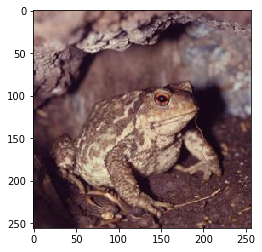

In [ ]:
for batch_idx, (mri, image) in enumerate(trainloader):
    print(mri.shape)
    print(image.shape)
    
    import matplotlib.pyplot as plt
    # image = np.transpose(image,(1,2,0))
    plt.imshow(image[0].squeeze().permute(1,2,0), interpolation='nearest')
    plt.show()
    break

In [ ]:
fmri_data_bd = bdpy.BData("/Users/jaikar/Downloads/data/fmri/sub-01_perceptionNaturalImageTraining_original_VC.h5")

fmri_labels = fmri_data_bd.get('Label')[:, 1].flatten()

# Convet image labels in fMRI data from float to file name labes (str)
fmri_labels = ['n%08d_%d' % (int(('%f' % a).split('.')[0]),
                             int(('%f' % a).split('.')[1]))
               for a in fmri_labels]

fmri_data = fmri_data_bd.select('ROI_VC = 1')

print(fmri_labels[0])

print(fmri_data[0])


n01639765_47681
[-7.95109247  4.67269165 -0.36804574 ...  2.45975614  9.20861941
 -6.8299304 ]


In [ ]:
fmri_data.shape

In [ ]:
val_dataset = MyDataset(X_path="validation/X.pt", y_path="validation/y.pt")

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

NameError: name 'MyDataset' is not defined

In [ ]:
sub01_h5_path = 'fmri/sub-01_perceptionNaturalImageTraining_original_VC.h5'

In [ ]:
output_dir = "/Users/jaikar/Downloads/data/images/lmdb_training"

image.shape

(500, 500, 3)

In [ ]:
import matplotlib.pyplot as plt
# image = np.transpose(image,(1,2,0))
plt.imshow(image, interpolation='nearest')
plt.show()

In [ ]:
def get_image_tensor(image_id, lmdb_dir = "")
    env = lmdb.open(output_dir)
    with env.begin(write=True) as txn:
        image = (pickle.loads(txn.get(image_id.encode("ascii"))).get_image())
        return torch.from_numpy(image)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc = nn.Sequential(
                    nn.Linear(11726, 4096),
                    nn.ReLU(), 
                    nn.Linear(4096, 4096),
                    nn.ReLU(),
                    nn.Linear(4096, 4096),
                    nn.ReLU()
                    )
        
        
        
        self.upsample = nn.Sequential(
                    nn.BatchNorm2d(256),
                    nn.Upsample(scale_factor=2),
                    nn.Conv2d(256, 256, 3, stride=1, padding=1),
                    nn.BatchNorm2d(256),
                    nn.ReLU(),
                    nn.Upsample(scale_factor=4),
            
                    nn.Conv2d(256, 128, 3, stride=1, padding=1),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),
                    nn.Upsample(scale_factor=2),
                    
                    nn.Conv2d(128, 64, 3, stride=1, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.Upsample(scale_factor=2),
            
                    nn.Conv2d(64, 32, 3, stride=1, padding=1),
                    nn.BatchNorm2d(32),
                    nn.ReLU(),
                    nn.Upsample(scale_factor=2),
            
                    nn.Conv2d(32, 3, 3, stride=1, padding=1),
                    nn.Tanh(),
        
        )
        
        

#         self.upsample = nn.Sequential(
#             nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),
#             nn.ReLU(),
# #             nn.BatchNorm2d(3),
#             nn.ConvTranspose2d(256, 512, 3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(512, 512, 3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(256, 256, 3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(128, 128, 3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
#             nn.ReLU()
                        
#         )


    def forward(self, input):
        input = self.fc(input)
        N = input.size(0)
        input = input.reshape(N, 256, 4, 4)
        input = self.upsample(input)
        return input

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18,ResNet18_Weights
import torchvision.transforms as T


class Comparator(nn.Module):
    def __init__(self):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT
        self.encoder = resnet18(weights=weights)
        self.transforms = weights.transforms()

    def forward(self, x):
        self.features = []

        x = self.transforms(x)
        x = x.type(torch.DoubleTensor).to(device)

        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        x = self.encoder.relu(x)
        x = self.encoder.maxpool(x)
        self.features.append(x)

        x = self.encoder.layer1(x)
        self.features.append(x)

        x = self.encoder.layer2(x)
        self.features.append(x)

        x = self.encoder.layer3(x)
        self.features.append(x)

        x = self.encoder.layer4(x)
        self.features.append(x)

        x = self.encoder.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.encoder.fc(x)
        self.features.append(x)
        # we take the 3rd output feature map of 
        # size 8 x 8 from the resnet18 encoder, 256 channels
        return self.features[3].type(torch.float64)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 =  nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=4),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        
        self.conv_2 =  nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)

        )

        
        self.conv_3 =  nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        
        self.conv_4 =  nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        
        self.conv_5 =  nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.AvgPool2d(11,stride=11),
#             nn.BatchNorm2d(256),

#             nn.Dropout2d(0.5)
        
        )
        
        
        self.fc = nn.Sequential(
                    nn.Linear(256, 256),
                    nn.ReLU(), 
#                     nn.Dropout(p=0.5),
                    nn.Linear(256, 1),
                    nn.Sigmoid()
                    )


    def forward(self, input):
        N = input.size(0)
        input = input.type(torch.DoubleTensor).to(device)
        input = self.conv_1(input)
        input = self.conv_2(input)
        input = self.conv_3(input)
        input = self.conv_4(input)
        input = self.conv_5(input)
        input = input.reshape(N,256)
        input = self.fc(input)
        return input
#         return nn.log_softmax(input,dim=1).type(torch.float64)

In [ ]:
def image_loss(images, generated_images):
    criterian = nn.MSELoss()
    loss = criterian(generated_images,images)
    return loss
    

def feature_loss(feature_images, feature_generated_images):
    with torch.no_grad():
        criterian = nn.MSELoss()
        loss = criterian(feature_generated_images,feature_images)
        return loss
        

def adverserial_loss(discriminator_preds_generated_images):
    labels = torch.ones_like(discriminator_preds_generated_images)
    criterian = nn.BCELoss()
    loss = criterian(discriminator_preds_generated_images,labels)
    return loss
    

def discriminator_loss(discriminator_preds_images,discriminator_preds_generated_images):
    criterian = nn.BCELoss()
    labels_images = torch.ones_like(discriminator_preds_images)
    labels_gen_images = torch.zeros_like(discriminator_preds_generated_images)
    loss1 = criterian(discriminator_preds_images, labels_images)
    loss2 = criterian(discriminator_preds_generated_images, labels_gen_images)
    loss = loss1+loss2
    return loss

In [ ]:
def train(epoch, trainloader):
        
        running_discr_loss = 0
        running_generator_loss = 0
        for i, (mris, images) in enumerate(trainloader):

            mris,images = mris.to(device), images.to(device)
           
            generator_optimizer.zero_grad()
            generated_images = generator(mris)
            # print(generated_images.is_cuda)
            
            feature_images = comparator(images)
            feature_generated_images = comparator(generated_images)
            discriminator_preds_generated_images = discriminator(generated_images)

            # img_loss = image_loss(images, generated_images)
            feat_loss = feature_loss(feature_images,feature_generated_images)
            adv_loss = adverserial_loss(discriminator_preds_generated_images)
            generator_loss = adv_loss  + feat_loss
            # print(img_loss)
            print(feat_loss)
            print(adv_loss)
            
            generator_loss.backward()
            generator_optimizer.step()
            
            discriminator_optimizer.zero_grad()
            
            discriminator_preds_images = discriminator(images)
            discr_loss = discriminator_loss(discriminator_preds_images,discriminator(generated_images.detach()))

            discr_loss.backward()
            discriminator_optimizer.step()
            
            running_discr_loss = running_discr_loss + discr_loss

            

            
            running_generator_loss = running_generator_loss + generator_loss
            

            if (i) % 10 == 0:
                print(f'Iter {i+1} | Discriminator Loss: {running_discr_loss / (i+1)} Generator Loss: {running_generator_loss / (i+1)}')
            
        avg_running_discr_loss = float(running_discr_loss / len(trainloader))
        avg_running_generator_loss = float(running_generator_loss / len(trainloader))
        print(f'Epoch: {epoch+1} | Discriminator Loss: {avg_running_discr_loss}, Generator Loss: {avg_running_generator_loss} \n')

In [ ]:
generator = Generator()
generator.to(device)

comparator = Comparator()
comparator.to(device)
discriminator = Discriminator()
discriminator.to(device)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),lr=0.01, weight_decay=1e-4)

generator_optimizer = torch.optim.Adam(generator.parameters(),lr=0.001, weight_decay=1e-4)

# comparator.encoder.requires_grad_(False)
for epoch in range(5):
    train(epoch, trainloader)

RuntimeError: ignored

In [ ]:
next(discriminator.parameters()).is_cuda

True

AttributeError: ignored

In [ ]:
ResNet18_Weights.IMAGENET1K_V1.transforms

functools.partial(<class 'torchvision.transforms._presets.ImageClassification'>, crop_size=224)

torch.Size([1, 3, 256, 256])


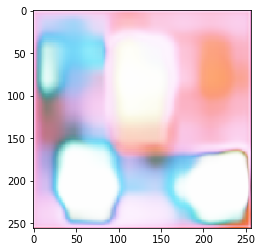

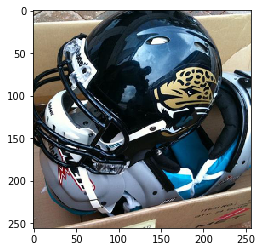

In [ ]:
for i, (mris, images) in enumerate(testloader):
    mris,images = mris.to(device), images.to(device)
    with torch.no_grad():
        generated_images = generator(mris)
        print(generated_images.shape)
        plt.imshow(generated_images[0].cpu().squeeze().permute(1,2,0), interpolation='nearest')
        plt.show()

        plt.imshow(images[0].cpu().squeeze().permute(1,2,0), interpolation='nearest')

        plt.show()
        break
        